In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import community as community_louvain  # ✅ Correct Import

# Connect to PostgreSQL
db_uri = {db_uri}
engine = create_engine(db_uri)

# Fetch influencer mentions (edges)
query = """
SELECT p.influencer_id AS source, i2.influencer_id AS target
FROM post_details pd
JOIN posts p ON pd.post_id = p.post_id
JOIN influencers i1 ON p.influencer_id = i1.influencer_id
JOIN influencers i2 ON i2.username = ANY(string_to_array(pd.usertags, ', '))
WHERE i2.influencer_id IS NOT NULL;
"""
df = pd.read_sql(query, engine)

# Fetch influencer usernames
usernames_query = "SELECT influencer_id, username FROM influencers;"
influencer_map = pd.read_sql(usernames_query, engine).set_index("influencer_id")["username"].to_dict()

engine.dispose()

# Build Graph
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row["source"], row["target"])

# Remove weakly connected influencers
degree_threshold = 5
G_filtered = G.subgraph([n for n, d in G.degree() if d >= degree_threshold])

# ✅ Compute Louvain communities (Fixed)
partition = community_louvain.best_partition(G_filtered)

# Assign cluster labels to each influencer
community_df = pd.DataFrame({
    "Influencer_ID": list(partition.keys()),
    "Username": [influencer_map.get(node, "Unknown") for node in partition.keys()],
    "Community": list(partition.values())
})

# Show top clusters
print(community_df.sort_values("Community").head(20))

      Influencer_ID             Username  Community
0                22         sandijarquin          0
1                23          victorialyn          0
34              107       stephleemakeup          0
67              214       makeupbyalinna          0
69              223          vannedoesit          0
70              224          raphaelamua          0
72              229           roseandben          0
74              234     captureyesstudio          0
75              235      marchbeautyword          0
76              240        theblondemann          0
77              241            rachleary          0
79              250         alanaahewitt          0
1283           7934           dulcecandy          0
82              257            carollago          0
83              266            chinabell          0
85              269               ewalkk          0
86              270             sharmkup          0
87              273         mandiglitter          0
88          

In [2]:
# Compute Louvain communities
partition = community_louvain.best_partition(G_filtered)

# Assign cluster labels to each influencer
community_df = pd.DataFrame({
    "Influencer_ID": list(partition.keys()),
    "Username": [influencer_map.get(node, "Unknown") for node in partition.keys()],
    "Community": list(partition.values())
})

# Show top clusters
print(community_df.sort_values("Community").head(20))

     Influencer_ID                    Username  Community
0               22                sandijarquin          0
1               23                 victorialyn          0
34             107              stephleemakeup          0
36             125              hayleynoellexo          0
38             127            hey_itsbeautiful          0
46             140                   stjohnnnn          0
45             138             lindsaysgotglam          0
40             132             katiejanehughes          0
50             157               pinkyboicourt          0
49             151                  lovleesazy          0
51             158                nadabeauty78          0
48             147                    _lahrin_          0
55             171                 jordrivera_          0
54             168              angelalamarie_          0
53             166  belle_of_the_ball_beauty83          0
52             165                  aura_glitz          0
61            

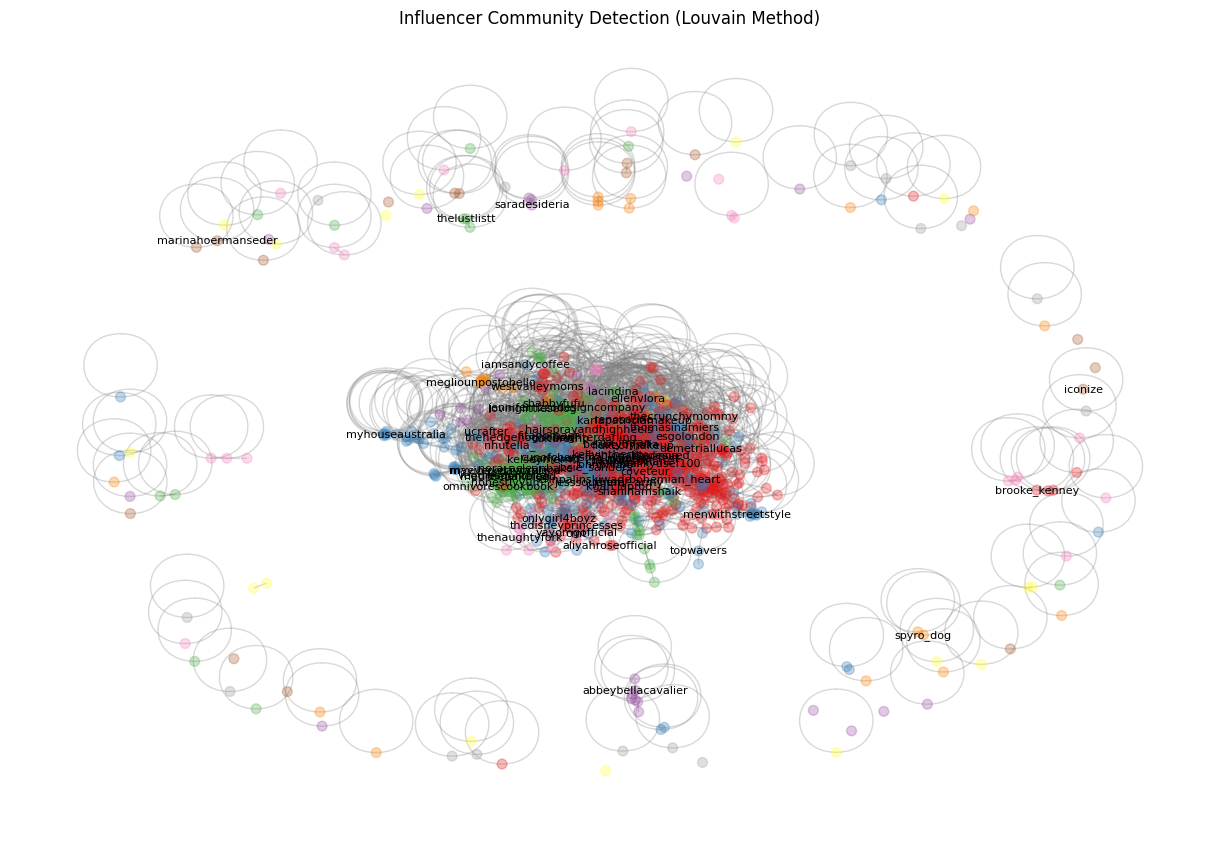

In [3]:
# Generate a layout for visualization
pos = nx.spring_layout(G_filtered, seed=42)

# Assign colors to communities
num_communities = len(set(partition.values()))
colors = [partition[node] for node in G_filtered.nodes()]

# Plot the graph with community colors
plt.figure(figsize=(12, 8))
nx.draw(G_filtered, pos, node_color=colors, cmap=plt.cm.Set1, node_size=50, edge_color="gray", alpha=0.3)
nx.draw_networkx_labels(G_filtered, pos, {node: influencer_map.get(node, "Unknown") for node in G_filtered.nodes() if np.random.rand() < 0.05}, font_size=8)
plt.title("Influencer Community Detection (Louvain Method)")
plt.show()

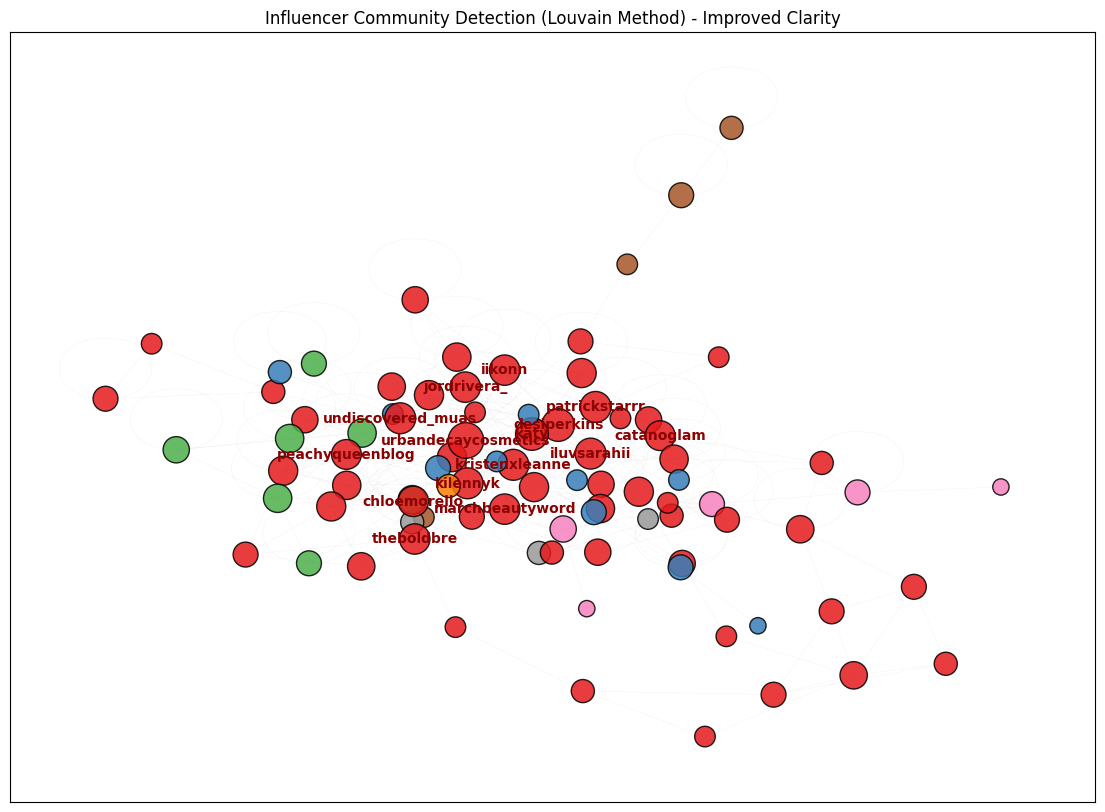

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import community as community_louvain

# Step 1: Compute Louvain communities
partition = community_louvain.best_partition(G_filtered)

# Step 2: Filter Top Influencers (Optional)
degree_threshold = 10  # Show only influencers with 10+ connections
G_visual = G_filtered.subgraph([n for n, d in G_filtered.degree() if d >= degree_threshold])

# Step 3: Assign community colors
num_communities = len(set(partition.values()))
colors = [partition[node] for node in G_visual.nodes()]

# Step 4: Compute node size (scale by degree)
node_sizes = [np.log1p(G_visual.degree(n)) * 200 for n in G_visual.nodes()]  # Log-scale to prevent huge nodes

# Step 5: Generate Layout (Kamada-Kawai for better spacing)
pos = nx.kamada_kawai_layout(G_visual)

# Step 6: Draw Graph
plt.figure(figsize=(14, 10))

# Draw nodes with community colors
nx.draw_networkx_nodes(G_visual, pos, node_size=node_sizes, node_color=colors, cmap=plt.cm.Set1, alpha=0.85, edgecolors="black")

# Draw edges with transparency
nx.draw_networkx_edges(G_visual, pos, alpha=0.1, width=0.3, edge_color="gray")

# Draw labels only for top influencers (PageRank-based)
top_influencers = sorted(G_visual.nodes(), key=lambda n: G_visual.degree(n), reverse=True)[:15]
nx.draw_networkx_labels(G_visual, pos, labels={n: influencer_map.get(n, "Unknown") for n in top_influencers}, font_size=10, font_color="darkred", font_weight="bold")

plt.title("Influencer Community Detection (Louvain Method) - Improved Clarity")
plt.show()

In [5]:
# Step 1: Compute Community Statistics

# 🔹 Count the number of unique communities
num_communities = len(set(partition.values()))

# 🔹 Find the size of each community
community_sizes = pd.Series(list(partition.values())).value_counts().sort_values(ascending=False)

# 🔹 Assign each influencer to their detected community
community_df = pd.DataFrame({
    "Influencer_ID": list(partition.keys()),
    "Username": [influencer_map.get(node, "Unknown") for node in partition.keys()],
    "Community": list(partition.values())
})

# 🔹 Find the top 10 most connected influencers in each community
top_influencers_per_community = community_df.groupby("Community").apply(
    lambda x: x.sort_values(by="Influencer_ID", ascending=True).head(3)  # Replace with degree centrality if needed
)

# Step 2: Print Key Insights

print(f"🔹 Total Number of Influencer Communities Detected: {num_communities}\n")

print("🔹 Top 5 Largest Communities (By Number of Influencers):")
print(community_sizes.head(5), "\n")

print("🔹 Top 3 Influencers in Each Community:")
print(top_influencers_per_community[["Community", "Username"]], "\n")

# Step 3: Identify Bridges (Influencers Connecting Multiple Communities)

# Compute betweenness centrality (identifies key bridge influencers)
betweenness = nx.betweenness_centrality(G_filtered)
bridge_influencers = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]

print("🔹 Top 10 Bridge Influencers (Connecting Different Communities):")
for influencer, score in bridge_influencers:
    print(f"{influencer_map.get(influencer, 'Unknown')}: Betweenness Score {score:.4f}")

C:\Users\madhu\AppData\Local\Temp\ipykernel_30984\3057331571.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_influencers_per_community = community_df.groupby("Community").apply(


🔹 Total Number of Influencer Communities Detected: 133

🔹 Top 5 Largest Communities (By Number of Influencers):
0     170
33    124
4     122
6      96
26     77
Name: count, dtype: int64 

🔹 Top 3 Influencers in Each Community:
                Community          Username
Community                                  
0         0             0      sandijarquin
          1             0       victorialyn
          2             0   stephjoyner1989
1         399           1       kissmytulle
          479           1   rattlesandheels
...                   ...               ...
128       1234        128      highsnobiety
129       1259        129      fawn_parties
130       1275        130       eatplaycbus
131       1276        131  voortman_cookies
132       1278        132           boscovs

[221 rows x 2 columns] 

🔹 Top 10 Bridge Influencers (Connecting Different Communities):
urbandecaycosmetics: Betweenness Score 0.3433
thefeedfeed: Betweenness Score 0.1821
aliceliveing: Betweenness

In [6]:
community_df.to_sql('influencer_communities', engine, if_exists='replace', index=False)

314